<h2><b>Dispute Rates for Consumer Data</b></h2>

This is a simple exploratory data analysis for the Consumer Complaint Database of the CFPB (Consumer Financial Protection Bureau). This publicly available database tracks complaints made to the agency regarding financial products, from the date of the complaint and the issue at stake, to the company's response (timely or otherwise) and finally to the consumer's reaction to the response -- whether or not they chose to dispute it. The data can be found at https://www.consumerfinance.gov/data-research/consumer-complaints/#download-the-data. 

In [1]:
%matplotlib inline
import scipy, numpy as np, pandas as pd, sklearn, vincent, matplotlib as mp, matplotlib.pyplot as plt, datetime as dt
import geopy
#Read the Consumer Complaint Database into a Pandas dataframe.
df = pd.read_csv("Consumer_Complaints.csv",low_memory=False, parse_dates=True)
#Sort the dataframe by the complaint ID.
df = df.sort_values(by='Complaint ID')
#Convert Dates into date format
for col in df.columns:
    if 'Date' in col:
        df[col] = pd.to_datetime(df[col], format="%m/%d/%Y")
#Add some useful additional columns.
df['year'] = df['Date received'].apply(lambda d: d.year)
df['year-month'] = df['Date received'].apply(lambda d: dt.datetime(d.year, d.month, 1))

<h2>Helper Functions:</h2>

In [5]:
#This function counts unique elements in columns
def count_unique(dataframe, header_name):
    z = dataframe[header_name].unique()
    return sum(1 for v in z if pd.notnull(v))

#This function sorts a dictionary of counts by the count in descending order.
def sort_by_count(dictionary):
    ordered_list = sorted(dictionary.items(), key=lambda x: x[1])
    ordered_list.reverse()
    return ordered_list

#This function computes the percentage of missing data per header name for a sub-frame of the CCD.
def missing_percentage(dataframe, header_name):
    count = 0
    for x in dataframe[header_name]:
        try:
            if np.isnan(x):
                count+=1
        except TypeError:
            pass
    return (count/dataframe.shape[0])*100

#This function computes the dispute rate for a sub-frame of the CCD.
def dispute_rate(dataframe):
    count = 0
    try:
        for x in dataframe['Consumer disputed?']:
            if x == 'Yes':
                count+=1
        return 100*(count/dataframe.shape[0])
    except ZeroDivisionError:
        return 0
 


<h2>Is the data complete? How much is missing? How many unique options are there for each column?</h2>

In [7]:
r = []
for col in df.columns:
    r.append([col, missing_percentage(df,col),count_unique(df,col)])
missing_data = pd.DataFrame(r, columns=['Column Name', 'Missing (%)', 'Unique'])
print(missing_data)

                     Column Name  Missing (%)   Unique
0                  Date received     0.000000     2434
1                        Product     0.000000       18
2                    Sub-product    21.592543       76
3                          Issue     0.000000      166
4                      Sub-issue    46.407578      218
5   Consumer complaint narrative    71.734584   296475
6        Company public response    67.777925       10
7                        Company     0.000000     4914
8                          State     1.287822       63
9                       ZIP code     1.714586    29109
10                          Tags    86.260726        3
11    Consumer consent provided?    49.991369        4
12                 Submitted via     0.000000        6
13          Date sent to company     0.000000     2383
14  Company response to consumer     0.000459        8
15              Timely response?     0.000000        2
16            Consumer disputed?    29.434427        2
17        

We can see from above that a big chunk of the missing data is about the narrative -- most people prefer to fill out a form  briefly as well as the company's public response.

<h2> Complaints over Time </h2>

(0, 30000.0)

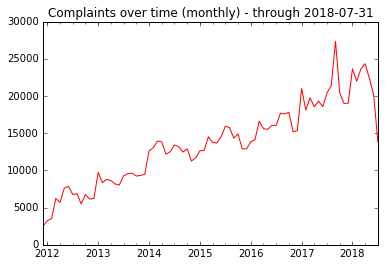

In [6]:
fig, axis = plt.subplots(1)
df['year-month'].value_counts().sort_index().plot(ax=axis,color='r')
maxdate = df['Date received'].max().strftime('%Y-%m-%d')
axis.set_title('Complaints over time (monthly) - through %s' % maxdate)
axis.set_ylim(0, axis.get_ylim()[1])

The above graph shows a general rise in complaints since the creation of the CFPB which could indicate a growing acceptance/awareness of the system as well as a growing tendency towards consumer failure in the marketplace. A curious spike in 2017 raises several questions about politics.


<h2> Companies with most complaints </h2>


Since the ratio of total number of complaints to the number of companies is 1089126 : 4914 or roughly 222 : 1, let's figure out the <b>top twenty companies</b> with the <b>most complaints</b> against them.

In [8]:
top_twenty_complaints = df['Company'].value_counts().iloc[:20]
print(top_twenty_complaints)

EQUIFAX, INC.                             90537
Experian Information Solutions Inc.       80169
BANK OF AMERICA, NATIONAL ASSOCIATION     76758
TRANSUNION INTERMEDIATE HOLDINGS, INC.    73049
WELLS FARGO & COMPANY                     64795
JPMORGAN CHASE & CO.                      53670
CITIBANK, N.A.                            43513
CAPITAL ONE FINANCIAL CORPORATION         29123
OCWEN LOAN SERVICING LLC                  26734
Navient Solutions, LLC.                   25622
NATIONSTAR MORTGAGE                       19066
SYNCHRONY FINANCIAL                       18326
U.S. BANCORP                              15360
Ditech Financial LLC                      13220
AMERICAN EXPRESS COMPANY                  11417
PNC Bank N.A.                             10586
ENCORE CAPITAL GROUP INC.                 10134
DISCOVER BANK                              8849
PORTFOLIO RECOVERY ASSOCIATES INC          8436
TD BANK US HOLDING COMPANY                 8343
Name: Company, dtype: int64


<h2> <b> Dispute Rates </b> </h2>

An interesting quantity to consider is the <b>dispute rate</b>: the percentage of times when consumers dispute the responses given by companies to consumers. There are 8 unique responses given by companies to consumers (<b>'Company response to customer'</b>). Let's compute the dispute rates for them.

In [6]:
for x in df['Company response to consumer'].unique():
    print(x, dispute_rate(df[df['Company response to consumer']==x]))

Closed with relief 13.382408456021139
Closed with non-monetary relief 11.879490707375135
Closed with explanation 21.66699718182761
Closed without relief 26.943962380339247
Closed with monetary relief 10.815735660342977
Closed 20.865678663843802
Untimely response 0.050352467270896276
In progress 0.0


We see that whenever there's relief (monetary or otherwise), consumers dispute the response at significantly lower rates. Are there any other factors that influence this?

To do this, we first look at the overall dispute rate. 

In [7]:
dispute_rate(df)

19.544659584375644

Let's say that a significant deviation from this dispute rate is 3%. Now, we compute the dispute rates when columns are set to particular values (which are at least 1% of their column, for statistical significance).

In [8]:
r = []
for i in range(0,19):
    x = missing_data.iloc[i]
    if(int(x['Unique']) <= 100):
        unique_cols = df[x['Column Name']].unique()
        for y in unique_cols:
            df1 = df[df[x['Column Name']]==y]
            count = dispute_rate(df1)
            if(abs(count-19.544) >= 3 and df1.shape[0]/df.shape[0]>=0.01):
                r.append([x['Column Name'], y, count])
z = pd.DataFrame(r, columns=['Column Name', 'Column Value', 'Dispute Rate'])
z.

,Column Name,Column Value,Dispute Rate
0,Product,Mortgage,22.790430
1,Product,Credit reporting,15.940919
2,Sub-product,Conventional fixed mortgage,24.470871
3,Sub-product,Conventional adjustable mortgage (ARM),25.924290
4,Sub-product,FHA mortgage,23.056769
5,Sub-product,Home equity loan or line of credit,26.564439
6,Sub-product,"Other (i.e. phone, health club, etc.)",16.423791
7,Sub-product,Payday loan,13.463214
8,Sub-product,Federal student loan servicing,16.213365
9,Issue,"Loan servicing, payments, escrow account",23.241814


We can draw some conclusions from this data. People tend to dispute the company response more when it's their home on the line -- mortgages and home loans being the key examples. People tend to dispute the company response on credit scores less. They also tend to dispute things less when the company has a certain public response (see row 21 above). When there's an issue about communication (rows 17-20) it appears that the company response is satisfactory enough to not warrant as many disputes. Interestingly, when the complaint was submitted via referral, postal mail or telephone, dispute rates are significantly lower. 




In [17]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,year,year-month
700882,2012-05-21,Credit card,NaN,Closing/Cancelling account,NaN,NaN,NaN,SYNCHRONY FINANCIAL,AZ,85053,NaN,NaN,Web,2012-05-23,Closed with relief,Yes,No,1,2012,2012-05-01
25520,2012-05-21,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,NATIONSTAR MORTGAGE,CA,93551,NaN,NaN,Referral,2012-05-29,Closed with non-monetary relief,Yes,No,5,2012,2012-05-01
653169,2012-05-21,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"CARRINGTON MORTGAGE SERVICES, LLC",CA,92567,NaN,NaN,Referral,2012-08-29,Closed with explanation,Yes,No,7,2012,2012-05-01
691578,2012-05-21,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,UNITED GUARANTY CORPORATION,MI,48412,NaN,NaN,Postal mail,2012-06-20,Closed with explanation,Yes,Yes,16,2012,2012-05-01
287443,2012-05-21,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,HSBC NORTH AMERICA HOLDINGS INC.,PA,19464,NaN,NaN,Referral,2012-05-21,Closed with non-monetary relief,Yes,No,20,2012,2012-05-01
